In [1]:
!pip freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.2.0
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.8
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
db-dtypes==1.0.4
debugpy==1.0.

In [2]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import pandas as pd
import nltk
import re
import xlrd
from wordcloud import WordCloud
from tqdm.autonotebook import tqdm
nltk.download('stopwords')
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
os.getcwd()

'/content'

In [5]:
path = '/content/drive/MyDrive/Data_examples/'

In [6]:
df = pd.read_excel(path + 'Corona_clustered.xlsx')

In [11]:
df = df.sample(n=1000)

In [7]:
stopwords_file = "stopwords_en.txt"
with open(path+stopwords_file, "r") as fh:
    stw = [line.strip().lower() for line in fh.readlines()]
stw += nltk.corpus.stopwords.words('english')

In [ ]:
stw

In [8]:
def cleaning(text,stw):
    text = str(text)
    text = text.lower()
    from string import punctuation
    punctuation += ":"+':'+"'"+"’"+"•"+'”'+"«"+"»"+"“"+"·"+"°"+"¿"
    text = re.sub(r"["+punctuation+"]"," ",text)
    text = re.sub(r"\d+"," ",text)
    for word in stw:
        text = re.sub(r"\b{}\b".format(word), " ", text)
    text = re.sub(r"\s+"," ", text)
    return text.strip()

In [9]:
tqdm.pandas()

In [12]:
df['text_postprocessed'] = df['cleaned_text'].progress_apply(cleaning, args = [stw])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True, verbose = 1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandarallel: filename=pandarallel-1.6.3-py3-none-any.whl size=16463 sha256=e840a1bc387c29769c4aae38f0dd1a54c474da7943263d64da0863a8cb4a6681
  Stored in directory: /root/.cache/pip/wheels/3c/a4/19/02a1f08d032a017d5d7e22da595aa652ba0a2f2e22de73981b
Successfully built pandarallel


In [14]:
from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()

In [15]:
n_cores

2

In [16]:
import time
t_in = time.time()
df['text_postprocessed'] = df['cleaned_text'].parallel_apply(cleaning, args = [stw])
t_ot = time.time()

In [17]:
print("done in = " + str(t_ot - t_in) + " seconds")


done in = 86.37068295478821 seconds


In [18]:
texts = df['text_postprocessed'].tolist()

In [19]:
example = ['AMSE is the best univ']

In [20]:
from nltk.tokenize import WhitespaceTokenizer
tk = WhitespaceTokenizer()
def get_frequencies(texts):
    all_tokens = []
    for doc in texts:
        all_tokens += tk.tokenize(doc)

    frequencies = Counter(all_tokens)
    return frequencies

In [21]:
toks = tk.tokenize(str(example))
toks

["['AMSE", 'is', 'the', 'best', "univ']"]

In [23]:
def generate_wc(frequencies,font_path=None):
    """
    Generates a WordCloud object from frequencies, after removing words with frequency < 5
    :param frequencies: dict: keys are words, values are frequencies
    :return: WordCloud object
    """
    frequencies = {w: f for w, f in frequencies.items() if f >= 5}
    if len(frequencies) <= 1:
        raise ValueError("Not enough words to plot on the wordcloud : only {} word(s) with frequency >= 5".format(
            len(frequencies)))
    if font_path is not None:
        wc = WordCloud(width=1600, height=800,background_color="white", colormap="nipy_spectral",font_path=font_path)
    else:
        wc = WordCloud(width=1600, height=800,background_color="white", colormap="nipy_spectral")
    wc.generate_from_frequencies(frequencies)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, aspect="equal")
    plt.axis("off")
    #plt.close()
    plt.savefig(path+'wordcloud.jpg')
    
    return wc

In [24]:
frequencies = get_frequencies(texts)

In [ ]:
frequencies

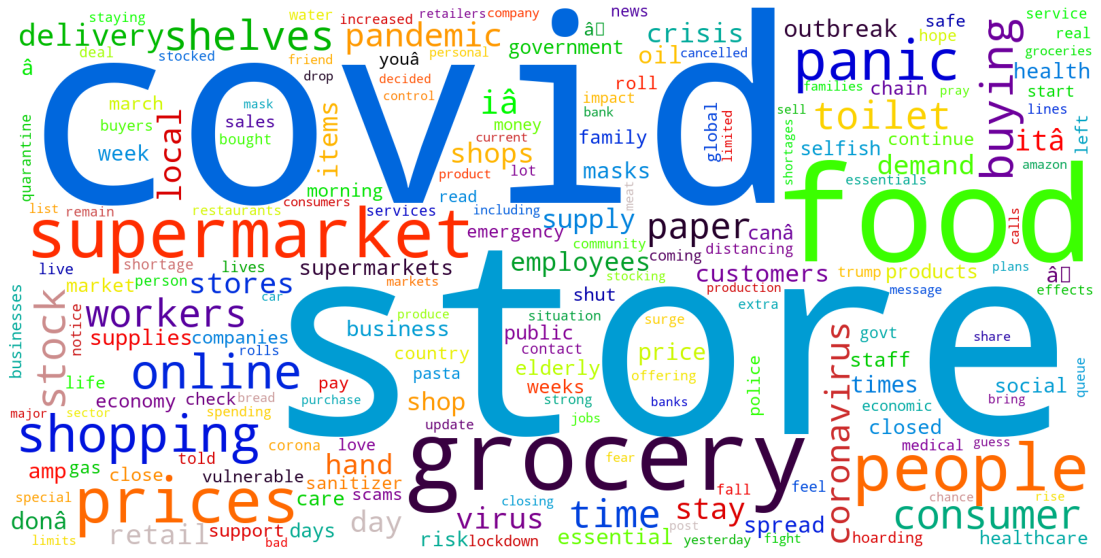

In [26]:
generate_wc(frequencies)

In [27]:
def generate_wc_cluster(frequencies,cluster_id,limit = 5,font_path=None):
    """
    Generates a WordCloud object from frequencies, after removing words with frequency < 5
    :param frequencies: dict: keys are words, values are frequencies
    :return: WordCloud object
    """
    frequencies = {w: f for w, f in frequencies.items() if f >= limit}
    if len(frequencies) <= 1:
        raise ValueError("Not enough words to plot on the wordcloud : only {} word(s) with frequency >= 5".format(
            len(frequencies)))
    if font_path is not None:
        wc = WordCloud(width=1600, height=800,background_color="white", colormap="nipy_spectral",font_path=font_path)
    else:
        wc = WordCloud(width=1600, height=800,background_color="white", colormap="nipy_spectral")
    wc.generate_from_frequencies(frequencies)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, aspect="equal")
    plt.axis("off")
    #plt.close()
    plt.savefig(path+'wordcloud_{}.jpg'.format(cluster_id))
    
    return wc

In [28]:
df.Cluster.value_counts()

13    68
7     67
4     63
8     62
5     60
2     56
18    54
0     52
3     50
19    50
6     48
14    47
10    46
11    45
12    45
17    44
1     41
15    37
9     33
16    32
Name: Cluster, dtype: int64

In [29]:
for i in tqdm(sorted(set(df.Cluster.tolist()))):
  cluster_texts = df[df['Cluster']==i]['text_postprocessed'].tolist()
  frequencies = get_frequencies(cluster_texts)
  wc = generate_wc_cluster(frequencies,i, limit = 2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def frequencies_to_pdf(frequencies, out,font_path=None):

    plt.ioff()
    with PdfPages(out) as pdf:
        for current_freqs in frequencies:
            if font_path is not None:
                current_wc = WordCloud(width=1600, height=800,background_color="white", colormap="nipy_spectral",font_path=font_path)
            else:
                current_wc = WordCloud(width=1600, height=800,background_color="white", colormap="nipy_spectral")
            current_wc.generate_from_frequencies(current_freqs)
            plt.figure(figsize=(20,10))
            plt.imshow(current_wc, aspect="equal")
            plt.axis("off")
            pdf.savefig()
            plt.close()